## Introduction

Found help here: https://medium.com/@bpothier/generating-structured-data-from-an-image-with-gpt-vision-and-langchain-34aaf3dcb215

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Loading the image

We need it to encode images to base64.

Also, we need to ensure we can easily integrate the function with Langchain

In [2]:
import base64

def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
  
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

Integrating with LangChain

In [3]:
from langchain.chains.transform import TransformChain

load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

Describing the fields of our structured output

In [50]:
from langchain_core.pydantic_v1 import BaseModel, Field

class ArtSuggestion(BaseModel):
    """Information about the decorations to hang on the wall of the room."""
    art_type: str = Field(description="the type of the poster to be created.")
    description: str = Field(description="a more detailed description of the poster to be created.")
    #  main_objects: list[str] = Field(description="list of the main objects on the picture")

class Person(BaseModel):
    """Information about the person living in the home based on interior design."""
    personality: str = Field(description="a brief description person's personality.")
    taste: str = Field(description="keywords desribing the taste of the person.")
    
class Response(BaseModel):
    """Combining personality with art suggestions"""
    design: str = Field(description="A detailed description of the interior design from the image.")
    person: Person
    art_suggestions: list[ArtSuggestion] = Field(description="A list of 5 decorations (to hang on the wall) that would match personality and taste of the person and the interior design.")

### The model setup

In [58]:
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=Response)

# Set verbose
globals.set_debug(False)

@chain
def image_model(inputs: dict) -> dict:
    """Invoke model with image and prompt."""
    model = ChatOpenAI(temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)
    msg = model.invoke(
        [HumanMessage(
            content=[
                {"type": "text", "text": inputs["prompt"]},
                {"type": "text", "text": parser.get_format_instructions()},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
            ])]
        )
    return msg.content

In [53]:
vision_prompt_old = """
You are an agent specializing in home decorations and psychology.

You will be provided with an image of a room in a home.

Based on the image, you will do your best at describing the person living in the home.

You will think of the following details:
1. What's the taste of the person?
2. What's the personality?
And similar ones.

Then, you create a general picture of the person (or people) and describe it.
"""

vision_prompt = """
Given the image, provide the following information:
- a detailed description of the interior design
- a personality and taste of the person who loves spending time in the place on the image
- a list of 5 poster decorations that would perfectly match the exisiting design with person's taste and personality
"""

In [55]:
def get_image_informations(image_path: str) -> dict:
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "images/LivingRoom1.png",
  "prompt": "\nGiven the image, provide the following information:\n- a detailed description of the interior design\n- a personality and taste of the person who loves spending time in the place on the image\n- a list of 5 poster decorations that would perfectly match the exisiting design with person's taste and personality\n"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "images/LivingRoom1.png",
  "prompt": "\nGiven the image, provide the following information:\n- a detailed description of the interior design\n- a personality and taste of the person who loves spending time in the place on the image\n- a list of 5 poster decorations that would perfectly match the exisiting design with person's taste and personality\n"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:TransformChain] s] Exiting Chain ru
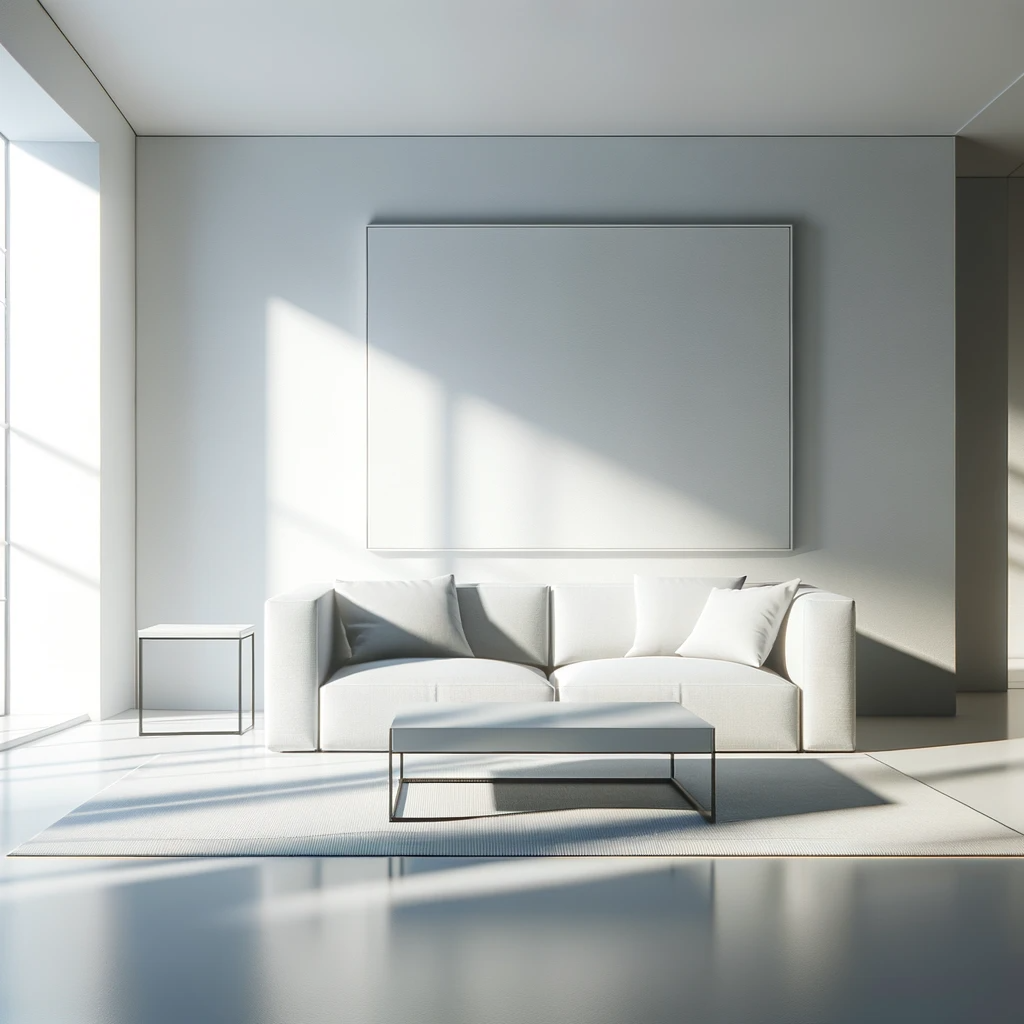

In [56]:
import pprint

result1 = get_image_informations("images/LivingRoom1.png")
pprint.pprint(result1, indent=2, width=120, depth=3)


[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "images/LivingRoom2.png",
  "prompt": "\nGiven the image, provide the following information:\n- a detailed description of the interior design\n- a personality and taste of the person who loves spending time in the place on the image\n- a list of 5 poster decorations that would perfectly match the exisiting design with person's taste and personality\n"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "images/LivingRoom2.png",
  "prompt": "\nGiven the image, provide the following information:\n- a detailed description of the interior design\n- a personality and taste of the person who loves spending time in the place on the image\n- a list of 5 poster decorations that would perfectly match the exisiting design with person's taste and personality\n"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:TransformChain] s] Exiting Chain ru
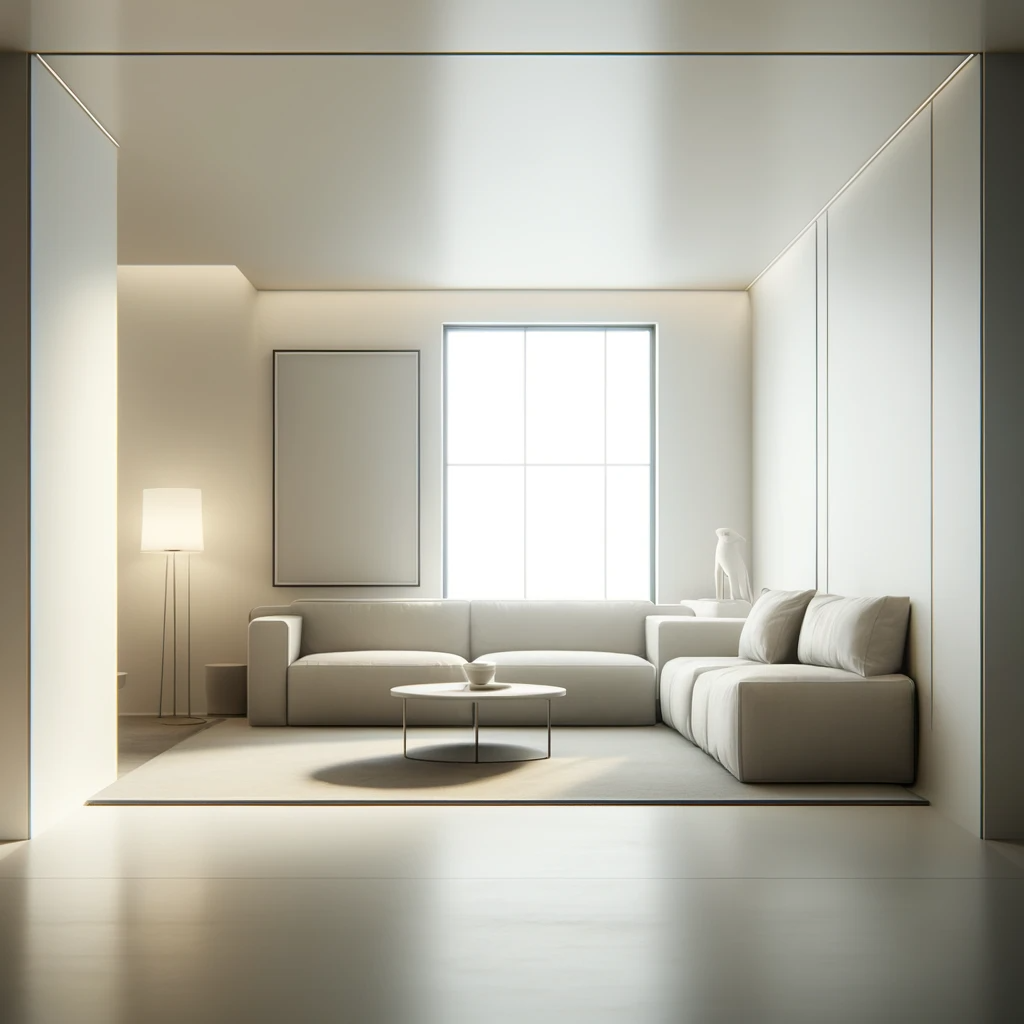

In [57]:
import pprint

result2 = get_image_informations("images/LivingRoom2.png")
pprint.pprint(result2, indent=2, width=120, depth=3)

{ 'art_suggestions': [ { 'art_type': 'Abstract Art',
                         'description': 'A large-scale abstract painting with a limited color palette that complements '
                                        "the room's hues. The artwork should feature geometric shapes or soft, flowing "
                                        'lines to maintain the minimalist theme.'},
                       { 'art_type': 'Black and White Photography',
                         'description': 'An elegant black and white photograph with architectural or natural subjects. '
                                        'The photograph should have a sense of depth and complexity without '
                                        'overwhelming the space.'},
                       { 'art_type': 'Minimalist Print',
                         'description': 'A simple, yet impactful minimalist print that uses negative space and a few '
                                        'well-chosen elements to create a stri

In [61]:
result1["person"]["personality"]

'The person who enjoys spending time in this space likely appreciates simplicity and order. They might be someone who values clarity, calmness, and a sense of openness in their living environment. This individual could be described as introspective, focused, and possibly introverted, with a preference for a space that serves as a serene retreat from the outside world.'

### The Middle model

In [76]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.llms import Ollama
from langchain_openai import ChatOpenAI

llama = Ollama(model="llama3")
gpt = ChatOpenAI()

gpt_prompt_text = """
Create a detailed description for a poster to hang on a wall for the person:
Personality of the person: <{personality}>,
Taste of the person: <{taste}>,

Here's additional information about the poster:
Art type: <{art_type}>,
Description: <{description}>.


You will only describe the piece of art.
"""

prompt_list = []

for art in result1["art_suggestions"][:2]:
    input_dict = {
        "personality": result1["person"]["personality"],
        "taste": result1["person"]["taste"],
        "art_type": art["art_type"],
        "description": art["description"],
    }

    gpt_prompt = PromptTemplate.from_template(gpt_prompt_text)
    chain = gpt_prompt | llama | StrOutputParser()
    
    response = chain.invoke(input_dict)
    print(response)
    print("**"*25)
    # gpt_prompt = gpt_prompt_template.invoke(input=input_dict)
    # prompt_list.append(gpt_prompt)

Here's a detailed description for the poster:

**Title:** Serenity

**Medium:** Abstract Painting

**Description:** This stunning abstract painting is a masterpiece of simplicity and sophistication, perfectly capturing the essence of serenity. A harmonious balance of white and grey tones dominates the canvas, creating a calming atmosphere that invites contemplation.

The main composition features soft, wispy brushstrokes in shades of creamy white, gradating from light to dark, like gentle morning mist. These strokes are subtly textured, giving the artwork a tactile quality that draws the viewer in.

Scattered throughout the painting are delicate flecks of pale grey, reminiscent of clouds drifting lazily across a clear blue sky. These subtle additions add a touch of visual interest without disrupting the overall sense of calm.

In the upper corners of the canvas, tiny bursts of color – soft blues and muted greens – peek out from beneath the dominant grey tones, like the first hints of d

In [72]:
from langchain_community.llms import Ollama

llm = Ollama(model="llama3")

for prompt in prompt_list[:2]:
    chain = prompt | llm
    llm_response = chain.invoke()
    print(llm_response)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'langchain_core.prompt_values.StringPromptValue'>

In [71]:
pprint.pprint(result1)

{'art_suggestions': [{'art_type': 'Abstract Painting',
                      'description': 'A large-scale abstract painting with a '
                                     'balance of white and grey tones, perhaps '
                                     'with subtle splashes of color to add '
                                     'visual interest without overwhelming the '
                                     'space.'},
                     {'art_type': 'Black and White Photography',
                      'description': 'A framed black and white photograph with '
                                     'architectural elements or natural '
                                     'landscapes that reflect the clean lines '
                                     'and simplicity of the room.'},
                     {'art_type': 'Minimalist Sculptural Art',
                      'description': 'A three-dimensional wall sculpture that '
                                     'plays with light and shadow, 

In [44]:
from openai import OpenAI
client = OpenAI()




completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant specializing in describing art to hang on a wall. You only describe the piece of art, nothing else."},
    {"role": "user", "content": gpt_prompt}
  ]
)

image_description = completion.choices[0].message


In [45]:
image_description

ChatCompletionMessage(content='**Poster Description:**\n\n**Title:** "Harmony in Minimalism"\n\n**Art Type:** Abstract Art\n\n**Description:** \n\nImmerse yourself in the serene world of minimalist beauty with this captivating large-scale abstract painting. The artwork is carefully crafted with a limited color palette, meticulously selected to complement the hues of your space. \n\nFeaturing a blend of geometric shapes and soft, flowing lines, this piece perfectly embodies the essence of modernity and sophistication that aligns with your contemporary taste. The clean lines and harmonious composition evoke a sense of order and serenity, reflecting your preference for an open and uncluttered environment.\n\nThis artwork is a visual symphony of simplicity and elegance, mirroring your streamlined lifestyle and appreciation for quality craftsmanship. Its neutral color scheme creates a feeling of cleanliness and spaciousness, enhancing the overall ambiance of your space.\n\nHang this abstrac

### Dalle 3

In [46]:
from openai import OpenAI

client = OpenAI()

prompt = """

"""

response = client.images.generate(
  model="dall-e-3",
  prompt=image_description.content,
  size="1024x1024",
  quality="standard",
  n=1,
)
image_url = response.data[0].url

In [47]:
image_url

'https://oaidalleapiprodscus.blob.core.windows.net/private/org-Xzj1yaisXt5cDNveMyg1I7wI/user-9YZozn3HQ3tv70cLgw6ILiKX/img-H1yQEpZJTkqhCek0JRQP3iXU.png?st=2024-04-25T08%3A11%3A18Z&se=2024-04-25T10%3A11%3A18Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-04-24T19%3A15%3A17Z&ske=2024-04-25T19%3A15%3A17Z&sks=b&skv=2021-08-06&sig=x7ghS91rObZ/p/BDSiRePV/SYLaCJVhsjXXyVexv14Y%3D'

### Testing Ollama

In [49]:
from langchain_community.llms import Ollama

llm = Ollama(model="llama2")

llm.invoke("Tell me a joke")

[llm/start] [1:llm:Ollama] Entering LLM run with input:
{
  "prompts": [
    "Tell me a joke"
  ]
}
[llm/end] [1:llm:Ollama] [14.73s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Sure, here's one:\n\nWhy don't scientists trust atoms?\nBecause they make up everything!\n\nI hope that made you smile! Do you want to hear another one?",
        "generation_info": {
          "model": "llama2",
          "created_at": "2024-04-25T09:54:17.774750631Z",
          "response": "",
          "done": true,
          "context": [
            518,
            25580,
            29962,
            3532,
            14816,
            29903,
            29958,
            5299,
            829,
            14816,
            29903,
            6778,
            13,
            13,
            29911,
            514,
            592,
            263,
            2958,
            446,
            518,
            29914,
            25580,
            29962,
         

"Sure, here's one:\n\nWhy don't scientists trust atoms?\nBecause they make up everything!\n\nI hope that made you smile! Do you want to hear another one?"